In [1]:
from nemo.collections.tts.models import TalkNetDursModel
from nemo.collections.tts.models import TalkNetSpectModel

pretrained_model_durs = "./dn2.ckpt"
pretrained_model_spec = "./sn2.ckpt"

dn = TalkNetDursModel.load_from_checkpoint(checkpoint_path=pretrained_model_durs)

sn = TalkNetSpectModel.load_from_checkpoint(checkpoint_path=pretrained_model_spec)


[NeMo W 2020-10-05 05:37:07 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-05 05:37:07 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharWithDursDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-05 05:37:07 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-05 05:37:07 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-05 05:37:07 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimenta

[NeMo I 2020-10-05 05:37:08 features:241] PADDING: 1
[NeMo I 2020-10-05 05:37:08 features:254] STFT using conv


In [2]:
text_to_generate = input("Input what you want the model to say: ")

Input what you want the model to say: hello


In [3]:
tokens = sn.parse(text_to_generate)
tokens = tokens.reshape(1, -1)
print(tokens)


tensor([[ 7, 27, 10, 36]])


In [4]:

from nemo.utils import talknet_utils

import torch

tokens_len = torch.tensor(len(tokens))
tokens_with_blanks, tokens_len = talknet_utils.interleave_blanks(tokens, tokens_len, dn.vocab)
print(tokens_with_blanks)

tensor([[57,  7, 57, 27, 57, 10, 57, 36, 57]])


In [5]:
durs_log = dn.forward(text=tokens_with_blanks, text_len=torch.tensor([1]))

print(durs_log)

tensor([[0.8438, 1.5537, 1.5383, 1.5431, 1.5131, 1.6001, 1.5296, 1.6072, 1.5686]],
       grad_fn=<SqueezeBackward1>)


In [6]:
durs = (durs_log.exp() + 1).long()
print(durs)
print(durs.sum())

tensor([[3, 5, 5, 5, 5, 5, 5, 5, 5]])
tensor(43)


In [7]:
tokens_expanded, tokens_len = talknet_utils.repeat_interleave(tokens_with_blanks, durs)
print(tokens_expanded, tokens_len)

tensor([[57, 57, 57,  7,  7,  7,  7,  7, 57, 57, 57, 57, 57, 27, 27, 27, 27, 27,
         57, 57, 57, 57, 57, 10, 10, 10, 10, 10, 57, 57, 57, 57, 57, 36, 36, 36,
         36, 36, 57, 57, 57, 57, 57]]) tensor([43])


In [27]:
spectrogram = sn(text=tokens_expanded, text_len=tokens_len).cuda()
print(spectrogram)

tensor([[[-8.5898, -7.3622, -8.5095,  ..., -8.3210, -8.7814, -8.6586],
         [-8.0608, -6.7832, -7.7931,  ..., -7.2253, -7.5702, -7.5420],
         [-7.5969, -6.4124, -7.0537,  ..., -6.3487, -6.4905, -6.6390],
         ...,
         [-5.8576, -4.1380, -4.2582,  ..., -8.1198, -8.0656, -8.3248],
         [-5.7362, -4.0953, -4.2358,  ..., -8.1738, -8.0545, -8.2310],
         [-5.8610, -4.2649, -4.4649,  ..., -8.2278, -8.0411, -8.0719]]],
       device='cuda:0', grad_fn=<CopyBackwards>)


In [28]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [29]:
supported_audio_gen = ["griffin_lim", "waveglow", "squeezewave"]

print("Choose one of the following audio generators:")
print([model for model in supported_audio_gen])
audio_generator = input()

assert audio_generator in supported_audio_gen

Choose one of the following audio generators:
['griffin_lim', 'waveglow', 'squeezewave']
waveglow


In [30]:
from omegaconf import OmegaConf, open_dict
import torch
from ruamel.yaml import YAML
from nemo.collections.asr.parts import parsers

SAMPLE_RATE = 22050
NFFT = 1024
NMEL = 80
FMAX = None

def load_vocoder_model():
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel as VocoderModel
        pretrained_model = "WaveGlow-22050Hz"
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel as VocoderModel
        pretrained_model = "SqueezeWave-22050Hz"
    elif audio_generator == "griffin_lim":
        from nemo.collections.tts.helpers.helpers import griffin_lim
        import numpy as np
        import librosa
        class GL:
            def __init__(self):
                pass
            def convert_spectrogram_to_audio(self, spec):
                log_mel_spec = spec.squeeze().to('cpu').numpy().T
                mel_spec = np.exp(log_mel_spec)
                mel_pseudo_inverse = librosa.filters.mel(SAMPLE_RATE, NFFT, NMEL, fmax=FMAX)
                return griffin_lim(np.dot(mel_spec, mel_pseudo_inverse).T ** 1.2)
            def load_state_dict(self, *args, **kwargs):
                pass
            def cuda(self, *args, **kwargs):
                return self
        return GL()
    else:
        raise NotImplementedError

    model = VocoderModel.from_pretrained(pretrained_model)
    with open_dict(model._cfg):
        global SAMPLE_RATE
        global NFFT
        global NMEL
        global FMAX
        if model._cfg.sample_rate is not None and SAMPLE_RATE is not None:
            assert model._cfg.sample_rate == SAMPLE_RATE
        if model._cfg.n_fft is not None and NFFT is not None:
            assert _cfg.n_fft == NFFT
        if model._cfg.n_mels is not None and NMEL is not None:
            assert model._cfg.n_mels == NMEL
        if model._cfg.fmax is not None and FMAX is not None:
            assert model._cfg.fmax == FMAX
    return model

vocoder = load_vocoder_model().cuda()

[NeMo I 2020-10-05 05:48:28 cloud:55] Found existing object /home/iglabutin/.cache/torch/NeMo/NeMo_1.0.0b1/WaveGlow-22050Hz/63a329dc3e8b44ec2e07cd4209eeab2a/WaveGlow-22050Hz.nemo.
[NeMo I 2020-10-05 05:48:28 cloud:61] Re-using file from: /home/iglabutin/.cache/torch/NeMo/NeMo_1.0.0b1/WaveGlow-22050Hz/63a329dc3e8b44ec2e07cd4209eeab2a/WaveGlow-22050Hz.nemo
[NeMo I 2020-10-05 05:48:28 common:395] Instantiating model from pre-trained checkpoint
[NeMo I 2020-10-05 05:48:33 features:241] PADDING: 16
[NeMo I 2020-10-05 05:48:33 features:254] STFT using conv
[NeMo I 2020-10-05 05:48:35 modelPT:237] Model WaveGlowModel was successfully restored from /home/iglabutin/.cache/torch/NeMo/NeMo_1.0.0b1/WaveGlow-22050Hz/63a329dc3e8b44ec2e07cd4209eeab2a/WaveGlow-22050Hz.nemo.


In [31]:
with torch.no_grad():
    audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.to('cpu').numpy()

In [32]:
if isinstance(spectrogram, torch.Tensor):
    spectrogram = spectrogram.to('cpu').detach().numpy()
if len(spectrogram.shape) == 3:
    spectrogram = spectrogram[0]

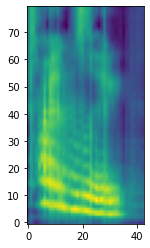

In [33]:
%matplotlib inline
imshow(spectrogram, origin="lower")
plt.show()

In [34]:
if isinstance(audio, torch.Tensor):
    audio = audio.to('cpu').numpy()
ipd.Audio(audio, rate=SAMPLE_RATE)